In [43]:
%matplotlib inline

import numpy as np
from scipy.sparse.linalg import spsolve
import nlfem
from mesh import trim_artificial_vertex
import plot
from conf import cfg_list
import os
import matplotlib.pyplot as plt

In [44]:
cfg = cfg_list[2]
vertices, elements, elementlabels = cfg["mesh"]
mesh = nlfem.meshFromArrays(elements, elementlabels, vertices, outputdim=1)
mesh, u, f = trim_artificial_vertex(mesh, None, None)

# Problem
Let $\tilde{\Omega}$ be compact and $\Omega$ be open in $\tilde{\Omega}$. We denote $\Gamma := \tilde{\Omega} \setminus \Omega$.
\begin{align*}
 \mathcal{L}u(x) = p.v. \int_{\tilde{\Omega} \cap B_\delta} 
 C(x,y)u(x) - C(y,x)u(y) dy 
\end{align*}

We seek to solve

\begin{align*}
&\mathcal{L}u = f \textrm{ in } \Omega \\
&u = g \textrm{ on } \Gamma \\
\end{align*}

# Domain

## Elements and element labels
 
 
 - Positve labels belong to $\Omega$
 - Negative labels to $\Gamma$
 - Elements with label 0 are ignored

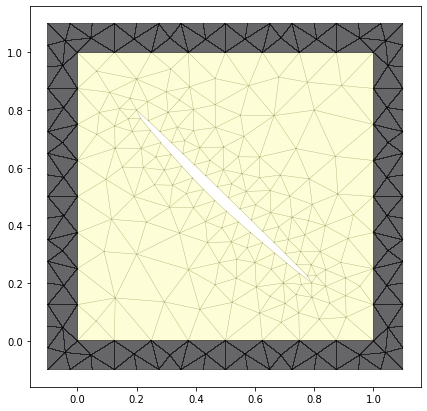

In [45]:
plot.plot_2d_diffusion_elementlabels(mesh)

## Vertex and node labels

If a set $A$ is closed in the continuous model we translate it in the following way. 

 > If a set $A$ is closed all vertices $x$ of elements $\mathcal{E} \subset A$ have the same label as $\mathcal{E}$.

 - $\tilde{\Omega} \subset \mathbb{R^2}$ is closed
 - Vertex labels are deduced such that $\Gamma \subset \tilde{\Omega} $ is closed

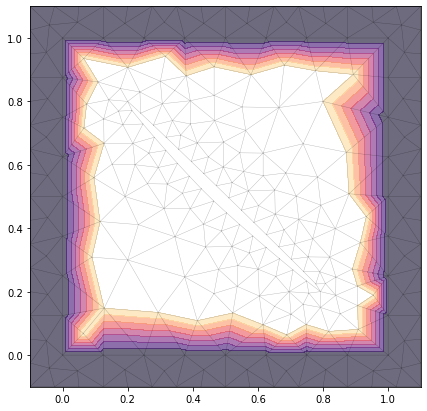

In [46]:
plot.plot_2d_diffusion_vertexlabels(mesh)

## Artificial elements

In general the set
\begin{align*}
    \tilde{\Omega} \cap B_\delta(x)
\end{align*}
is **not connected** for all $x$. Therefore a breadth first traversal set cannot traverse the whole interaction set. Adding artificial elements allows to guarantee, that the induced search graph is always connected. 
It is sufficient to add artificial elements at the boundary $\partial \tilde{\Omega}$.

In [55]:
cfg = cfg_list[2]
vertices, elements, elementlabels = cfg["mesh"]
mesh = nlfem.meshFromArrays(elements, elementlabels, vertices, outputdim=1)

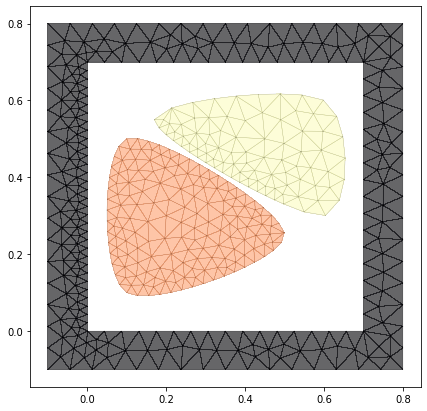

In [60]:
plot.plot_2d_diffusion_elementlabels(mesh)

In [57]:
cfg = cfg_list[0]
vertices, elements, elementlabels = cfg["mesh"]
mesh = nlfem.meshFromArrays(elements, elementlabels, vertices, outputdim=1)

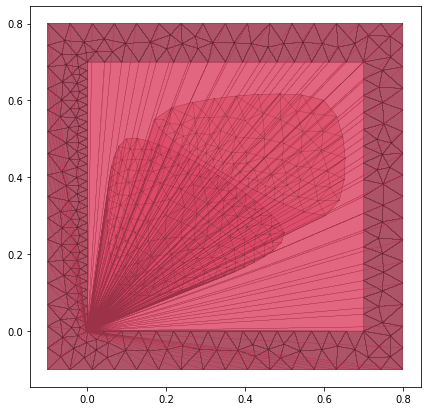

In [58]:
plot.plot_2d_diffusion_elementlabels(mesh)

# Kernel

## Kernel function

The kernel functions $C(x,\ell_x, y, \ell_y)$ have a common interface and depend on the points $x,y$ as well as the element labels $\ell_x, \ell_y$. They can be configured by a dictionary.

We hand over 
 - the of the kernel function `function`
 - the size of the interaction horizon `horizon`
 - the outputdimension of the kernel `outputdim` (1 for scalar, 2 for matrix-valued)
 - the fractional order `fractional_s` (optional).

In [41]:
kernel = {
            "horizon": 0.1
         }

## Preimplemented kernels

Preimplemented kernel functions are in 2D, i.e. options for `function`, are
 - "constant"
 - "constantLinf2D"
 - "linearPrototypeMicroelastic"
 - "linearPrototypeMicroelasticField" (outputdim 2)
 - "fractional" (requires fractional_s)

In [40]:
kernel["function"] = "linearPrototypeMicroelasticField"
kernel["outputdim"] = 2
kernel["fractional_s"] = -0.5

## Self defined kernels

You can define kernel functions yourself. The code as to be recompiled to use them.

Decleare your kernel by adding to *src/models.h*

Implement your kernel by adding to *src/models.cpp*

Make your kernel available by adding line 4 to *src/Cassemble.cpp* 

#  Integrarion routines

All the other configuration happens in a dictionary `conf`, which we set up now. **Different integration routines might be necessary on different pairs of elements.**

In [34]:
conf = {}


## Kernel truncation

Available integration routines are e.g. 
 - `retriangulate` truncation to $\ell_2-$ball with geometric error in $\mathcal{O}(h^2)$
 - `retriangulateLinfty`  truncation to $\ell_\infty-$ball without geometric error

In [35]:
conf["approxBalls"] = "retriangulate"

In [10]:
A = nlfem.stiffnessMatrix(mesh, kernel, conf)
ndlb = mesh["nodeLabels"]

A_O = A[ndlb > 0][:, ndlb > 0]
A_D = A[ndlb > 0][:, ndlb < 0]

g = np.apply_along_axis(load["dirichlet"], 1, vertices[mesh["vertexLabels"] < 0]).ravel()

f = nlfem.loadVector(mesh, load, conf)
#f[ndlb == 2] = 0.0
f_tilde = f[ndlb > 0] - A_D.dot(g)

u = np.zeros(mesh["nV"]*mesh["outdim"])
u[ndlb > 0] = spsolve(A_O, f_tilde)
u[ndlb < 0] = g
